In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [19]:
fhm = pd.read_csv(raw_dir/'fhm_cleaned.csv', index_col = [0])

In [20]:
fhm

,DTXSID,PREFERRED_NAME,CASRN,SMILES,QSAR_READY_SMILES,ChemClass_FHM,LC50_mg,LC50_mmol,MOA,MOA_Confidence
0,DTXSID3021691,4-(Hexyloxy)-m-anisaldehyde,61096-84-2,CCCCCCOC1=C(OC)C=C(C=O)C=C1,CCCCCCOC1=C(OC)C=C(C=O)C=C1,Aldehydes,2.67,0.01130,REACTIVE,D
1,DTXSID8021692,5-Bromo-2-nitrovanillin,98434-34-5,COC1=C(C(C=O)=CC(Br)=C1O)[N+]([O-])=O,COC1=C(C(C=O)=CC(Br)=C1O)[N+]([O-])=O,Aldehydes,73.30,0.26600,REACTIVE,D
2,DTXSID3021693,Dioctylisophthalate,4654-18-6,CCCCCCCCOC(=O)C1=CC(=CC=C1)C(=O)OCCCCCCCC,CCCCCCCCOC(=O)C1=CC(=CC=C1)C(=O)OCCCCCCCC,Phthalates,NaN,NaN,ND,NaN
3,DTXSID8021694,p-Chlorophenyl-o-nitrophenyl ether,39145-47-6,[O-][N+](=O)C1=C(OC2=CC=C(Cl)C=C2)C=CC=C1,[O-][N+](=O)C1=C(OC2=CC=C(Cl)C=C2)C=CC=C1,Diphenyl Ethers,1.92,0.00769,NARCOSIS I,B
4,DTXSID3021695,3'-Chloro-o-formotoluidide,71862-02-7,CC1=C(NC=O)C=CC=C1Cl,CC1=C(NC=O)C=CC=C1Cl,Secondary aromatic amines,46.60,0.27500,NARCOSIS I,C
...,...,...,...,...,...,...,...,...,...,...
612,DTXSID0022303,"3-(3,4-Dichlorophenoxy)benzaldehyde",79124-76-8,ClC1=C(Cl)C=C(OC2=CC=CC(C=O)=C2)C=C1,ClC1=C(Cl)C=C(OC2=CC=CC(C=O)=C2)C=C1,Aldehydes,0.30,0.00112,NARCOSIS I,B
613,DTXSID5022304,"2,4-Dinitro-1-naphthol sodium salt dihydrate (...",101836-92-4,O.O.[Na+].[O-]C1=C(C=C(C2=CC=CC=C12)[N+]([O-])...,OC1=C2C=CC=CC2=C(C=C1[N+]([O-])=O)[N+]([O-])=O,Phenols,4.24,0.01450,UNCOUPLER,A
614,DTXSID0022305,4-tert-Butylstyrene,1746-23-2,CC(C)(C)C1=CC=C(C=C)C=C1,CC(C)(C)C1=CC=C(C=C)C=C1,Benzenes,0.49,0.00306,REACTIVE,B
615,DTXSID5022306,Demeton,8065-48-3,CCOP(=O)(OCC)SCCSCC.CCOP(=S)(OCC)OCCSCC,,Other pesticides,16.00,0.06190,ACHE,A


In [21]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx



In [22]:
import karateclub
from sklearn.manifold import TSNE

In [23]:
def mol_embed(m, g):
    m.fit(g)
    X_embedding = m.get_embedding()
    tsne = TSNE(n_components=2,random_state=42)
    z = tsne.fit_transform(np.array(X_embedding))
    return z, X_embedding

In [24]:
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), feature = node_label)

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [25]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(fhm['DTXSID'], fhm['SMILES'])}

In [26]:
model_dict = {'ldp': karateclub.LDP(), 'gl2': karateclub.GL2Vec(), 'graph2vec':karateclub.Graph2Vec(attributed=True)}

In [27]:
results = {}
for k,v  in model_dict.items():
    results[k] = mol_embed(v, list(graphs.values()))

In [28]:
from sklearn.preprocessing import minmax_scale,StandardScaler
from scipy.spatial.distance import pdist,squareform

In [29]:
scaler = StandardScaler()

In [30]:
g2v = pd.DataFrame(scaler.fit_transform(results['graph2vec'][1]), index = graphs.keys())

In [44]:
g2v_df = pd.DataFrame(squareform(pdist(g2v, 'cosine')), index = graphs.keys(), columns = graphs.keys())

In [49]:
g2v_df.loc['DTXSID7022095']

g2v_df.loc['DTXSID7022095'].reset_index().sort_values(by = 'DTXSID7022095', ascending = True).head().set_index('index')

,DTXSID7022095
index,
DTXSID7022095,0.000000
DTXSID6022260,0.456052
DTXSID3020833,0.462290
DTXSID1021908,0.465585
DTXSID2022040,0.471816


In [51]:
g2v_df.loc[['DTXSID7022095'], ['DTXSID7022095',
 'DTXSID3021938',
 'DTXSID4021929',
 'DTXSID7021940',
 'DTXSID8021939']].T

,DTXSID7022095
DTXSID7022095,0.000000
DTXSID3021938,0.700785
DTXSID4021929,0.808413
DTXSID7021940,0.633001
DTXSID8021939,0.662066


In [50]:
fhm[fhm['DTXSID'].isin(['DTXSID7022095',
 'DTXSID6022260',
 'DTXSID3020833',
 'DTXSID1021908',
 'DTXSID2022040'])]

,DTXSID,PREFERRED_NAME,CASRN,SMILES,QSAR_READY_SMILES,ChemClass_FHM,LC50_mg,LC50_mmol,MOA,MOA_Confidence
217,DTXSID1021908,2-Methoxyethylamine,109-85-3,COCCN,COCCN,Primary aliphatic amines,524.00,6.97600,UNSURE,NaN
349,DTXSID2022040,"2,3-Dihydrobenzofuran",496-16-2,C1CC2=CC=CC=C2O1,C1CC2=CC=CC=C2O1,Cyclic Ethers,81.70,0.68000,NARCOSIS I,B
404,DTXSID7022095,1-Bromoheptane,629-04-9,CCCCCCCBr,CCCCCCCBr,Saturated Hydrocarbons,1.47,0.00821,NARCOSIS I,B
467,DTXSID3020833,Methyl tert-butyl ether,1634-04-4,COC(C)(C)C,COC(C)(C)C,Basic Ethers,672.00,7.62300,NARCOSIS I,C
569,DTXSID6022260,2-Chloro-1-methylpyridinium iodide,14338-32-0,[I-].C[N+]1=CC=CC=C1Cl,C[N+]1=CC=CC=C1Cl,Ammonium compounds,199.00,0.77900,UNSURE,NaN


In [ ]:
DTXSID1021908 	2-Methoxyethylamine 	
349 	DTXSID2022040 	2,3-Dihydrobenzofuran 	 	
404 	DTXSID7022095 	1-Bromoheptane 		
467 	DTXSID3020833 	Methyl tert-butyl ether 	
569 	DTXSID6022260 	2-Chloro-1-methylpyridinium iodide

<Axes: >

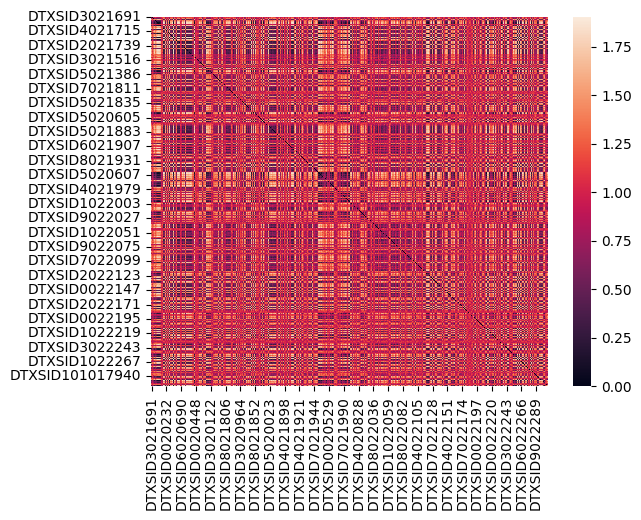

In [31]:
sns.heatmap(pd.DataFrame(squareform(pdist(g2v, 'cosine')), index = graphs.keys(), columns = graphs.keys()))

In [32]:
mydfs = []
for k, v in results.items():
    df = pd.DataFrame(v[0], columns = ['comp_1', 'comp_2'])
    df['approach'] = k
    df = pd.concat([df,fhm[['DTXSID','MOA']]], axis =1)
    df.columns = ['comp_1', 'comp_2','approach','DTXSID', 'MOA']
    
    mydfs.append(df)

In [37]:
aggregated

MOA
NARCOSIS I           241
REACTIVE              97
UNSURE                73
MIXED                 45
NARCOSIS II           38
ND                    36
NARCOSIS III          26
ACHE                  17
NARCOSIS I and II     13
UNCOUPLER             12
NEUROTOX               9
NEURODEP               6
BLOCK                  4
Name: count, dtype: int64

In [38]:
aggregated = mydfs[2]['MOA'].value_counts().copy()
misc = aggregated[aggregated <25].reset_index(name = 'count')['MOA'].tolist()
mydfs[2]['new_group'] = mydfs[2]['MOA'].apply(lambda x: 'misc' if x in misc else x)

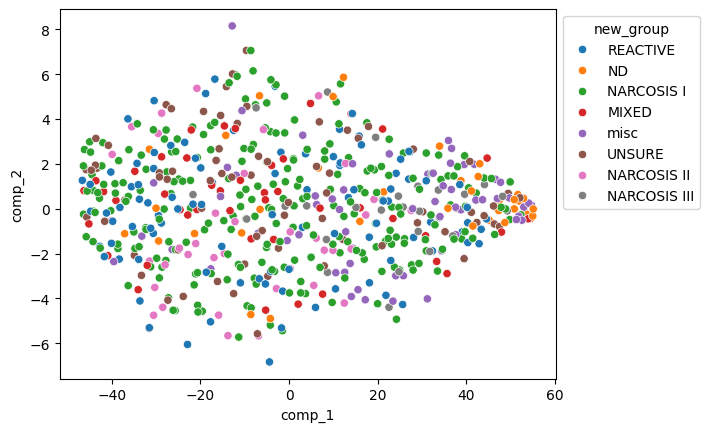

In [39]:
f, ax = plt.subplots()
ax = sns.scatterplot(data = mydfs[2], x = 'comp_1', y = 'comp_2', hue = 'new_group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
f.savefig(figures_dir/'tsne_fhm_graph2vec.png', dpi = 300,bbox_inches='tight')